# Прогноз количества заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

Введение:

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. 

Цель проекта:

Постройте модель для предсказания количество заказов такси на следующий час.

Содержание:
1. Подготовка
2. Анализ
3. Обучение
4. Тестирование

In [1]:
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor

In [2]:
RANDOM_STATE = 42

## Подготовка

In [3]:
pth1 = '/datasets/taxi.csv'
pth2 = 'taxi.csv'
if os.path.exists(pth1):
    taxi = pd.read_csv(pth1, index_col=[0], parse_dates=[0])
elif os.path.exists(pth2):
    taxi = pd.read_csv(pth2, index_col=[0], parse_dates=[0])
else:
    print('Something is wrong')

In [4]:
taxi.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [5]:
taxi.shape

(26496, 1)

In [6]:
taxi.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [7]:
# ресемплинг по по одному часу
taxi = taxi.resample('1H').sum()

<AxesSubplot:xlabel='datetime'>

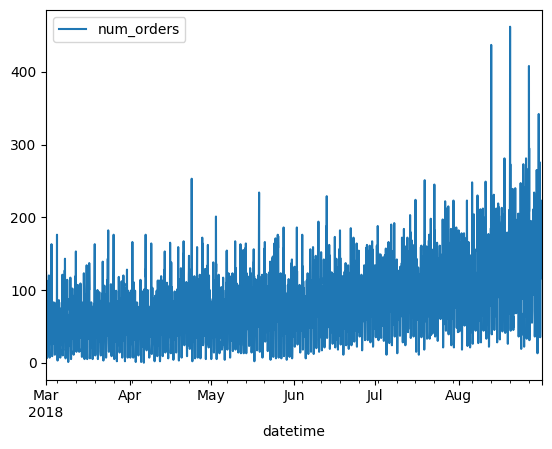

In [8]:
taxi.plot()

Загрузил данные. Провел ресемплинг по одному часу. Дубликатов нет.

## Анализ

In [9]:
taxi.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


In [10]:
def boxplot_(df, column):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

    sns.boxplot(data=df, x=column, ax=axes[0])
    axes[0].set_title(f'Ящик с усами для столбца "{column}"')
    axes[0].set_ylabel('Количество')

    sns.histplot(data=df, x=column, kde=True, ax=axes[1])
    axes[1].set_title(f'Гистограмма для столбца "{column}"')
    axes[1].set_ylabel('Частота')

    plt.tight_layout()
    plt.show()

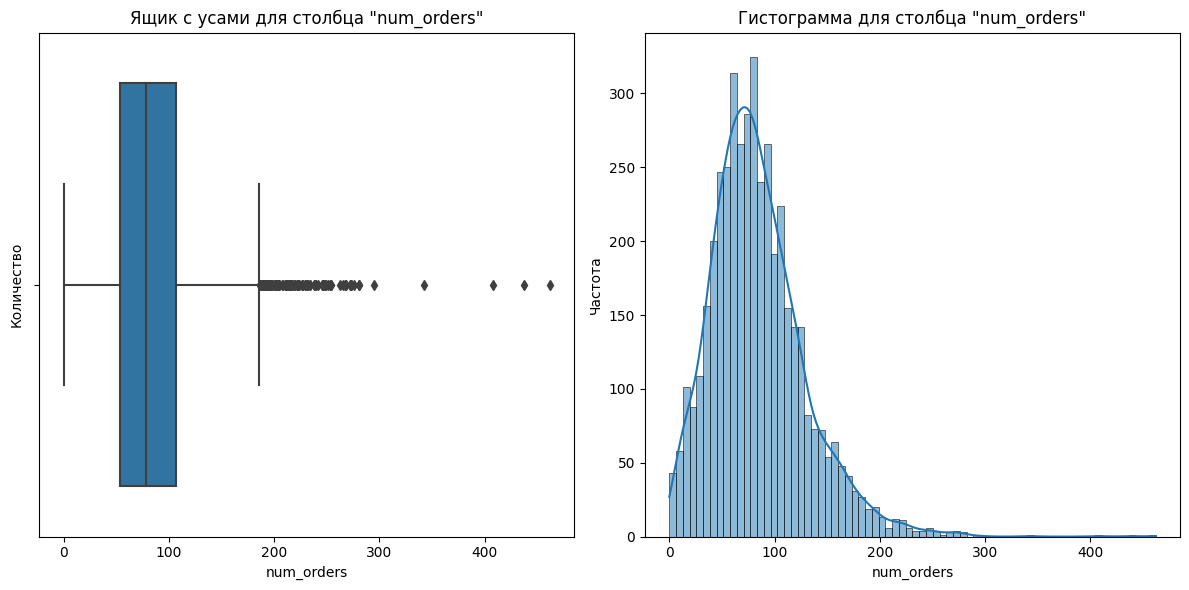

In [11]:
boxplot_(taxi, 'num_orders')

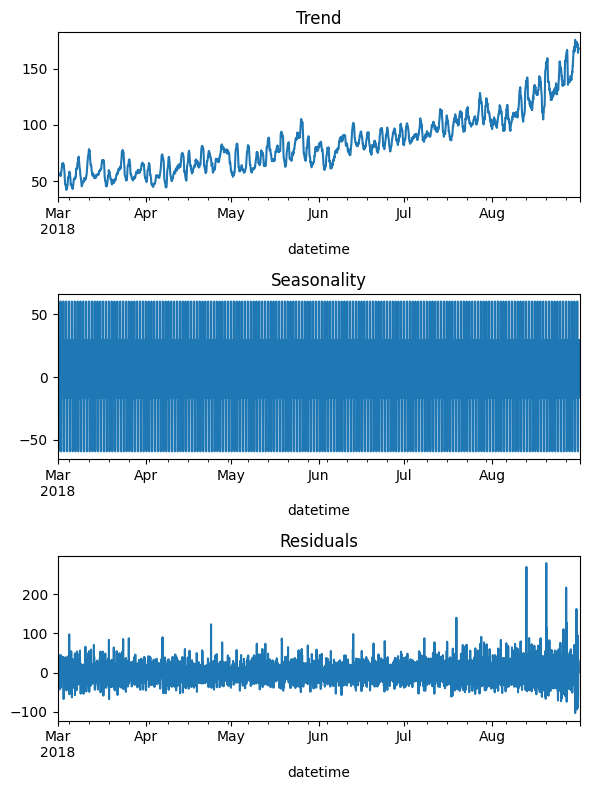

In [12]:
decomposed = seasonal_decompose(taxi)
plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca()) 
plt.title('Residuals')
plt.tight_layout()

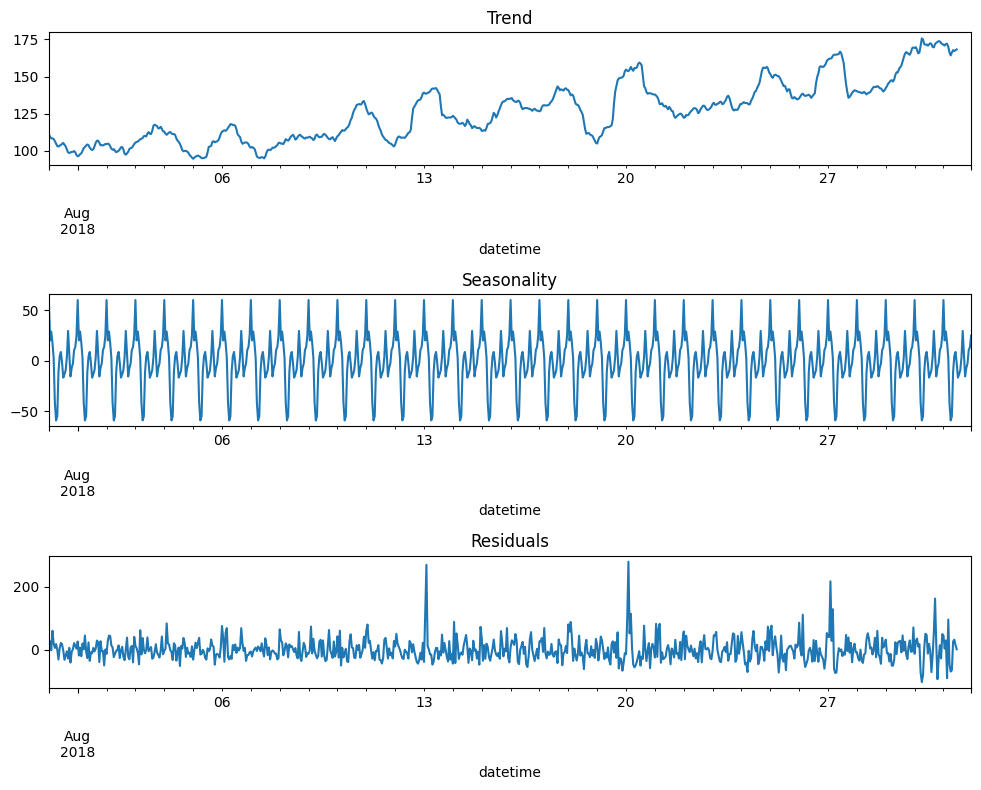

In [13]:
decomposed = seasonal_decompose(taxi)
plt.figure(figsize=(10, 8))
plt.subplot(311)
decomposed.trend['2018-07-31':'2018-08-31'].plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal['2018-07-31':'2018-08-31'].plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid['2018-07-31':'2018-08-31'].plot(ax=plt.gca()) 
plt.title('Residuals')
plt.tight_layout()

Провел анализ целевого признака num_orders количество заказов. 462 заказа рекордное значение. В среднем 78 заказов в час. На графиках вижу заканомерное увеличение количество заказов к концу лета. В рамках августа, там находится наша тестовая выборка, также вижу увеличение количества заказов к концу месяца. На графике сезонности видно закономерное изменение количества заказа в течении суток.

## Обучение

In [14]:
def make_features(df, max_lag, rolling_mean_size):
    data = df.copy()
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    return data

In [16]:
rmse_array = []
max_lag_array = []
rolling_mean_size__array = []
for i in range(1, 30):
    for k in range(1, 30):
        data = make_features(taxi, i, k)
        train, test_valid = train_test_split(data, shuffle=False, test_size=0.2)
        valid, test = train_test_split(test_valid, shuffle=False, test_size=0.5)
        train = train.dropna()
        X_train = train.drop(columns=['num_orders'])
        y_train = train['num_orders']
        X_valid = valid.drop(columns=['num_orders'])
        y_valid = valid['num_orders']
        X_test = test.drop(columns=['num_orders'])
        y_test = test['num_orders']
        model = LinearRegression()
        model.fit(X_train, y_train)
        preds = model.predict(X_valid)
        rmse = np.sqrt(mean_squared_error(y_valid, preds))
        rmse_array.append(rmse)
        max_lag_array.append(i)
        rolling_mean_size__array.append(k)

In [17]:
lr = pd.DataFrame({
    'rmse': rmse_array,
    'max_lag': max_lag_array,
    'rolling_mean_size': rolling_mean_size__array
}).sort_values(by='rmse').reset_index(drop=True)

In [18]:
lr

,rmse,max_lag,rolling_mean_size
0,34.005786,27,26
1,34.005786,27,17
2,34.005786,27,10
3,34.005786,27,22
4,34.005786,27,19
...,...,...,...
836,40.841807,2,2
837,40.841807,1,2
838,40.851225,2,28
839,40.859620,2,29


In [21]:
rmse_array = []
max_lag_array = []
rolling_mean_size__array = []
max_depth_array = []
min_samples_leaf_array = []
for i in range(1, 30):
    for k in range(1, 30):
        for max_depth in range(2, 5):
            for min_samples_leaf in range(2, 5):
                data = make_features(taxi, i, k)
                train, test_valid = train_test_split(data, shuffle=False, test_size=0.2)
                valid, test = train_test_split(test_valid, shuffle=False, test_size=0.5)
                train = train.dropna()
                X_train = train.drop(columns=['num_orders'])
                y_train = train['num_orders']
                X_valid = valid.drop(columns=['num_orders'])
                y_valid = valid['num_orders']
                X_test = test.drop(columns=['num_orders'])
                y_test = test['num_orders']
                model = DecisionTreeRegressor(random_state=RANDOM_STATE,
                                              max_depth=max_depth,
                                              min_samples_leaf=min_samples_leaf)
                model.fit(X_train, y_train)
                preds = model.predict(X_valid)
                rmse = np.sqrt(mean_squared_error(y_valid, preds))
                rmse_array.append(rmse)
                max_lag_array.append(i)
                rolling_mean_size__array.append(k)
                max_depth_array.append(max_depth)
                min_samples_leaf_array.append(min_samples_leaf)

In [22]:
tree = pd.DataFrame({
    'rmse': rmse_array,
    'max_lag': max_lag_array,
    'rolling_mean_size': rolling_mean_size__array,
    'max_depth': max_depth_array,
    'min_samples_leaf': min_samples_leaf_array
}).sort_values(by='rmse').reset_index(drop=True)

In [23]:
tree

,rmse,max_lag,rolling_mean_size,max_depth,min_samples_leaf
0,39.910486,28,14,4,3
1,39.910486,28,14,4,4
2,39.910556,29,14,4,4
3,39.910556,29,14,4,3
4,39.911522,25,14,4,3
...,...,...,...,...,...
7564,48.677689,3,3,2,4
7565,48.677689,3,3,2,3
7566,48.677689,3,3,2,2
7567,48.677689,2,3,2,2


Обучил модели методом линейной регресии и дерево принятие решения с разными гиперпараметрами.

## Тестирование

In [26]:
data = make_features(taxi, 27, 19)
train, test_valid = train_test_split(data, shuffle=False, test_size=0.2)
valid, test = train_test_split(test_valid, shuffle=False, test_size=0.5)
train = train.dropna()
X_train = train.drop(columns=['num_orders'])
y_train = train['num_orders']
X_valid = valid.drop(columns=['num_orders'])
y_valid = valid['num_orders']
X_test = test.drop(columns=['num_orders'])
y_test = test['num_orders']
model = LinearRegression()
model.fit(X_train, y_train)
preds = model.predict(X_test)
np.sqrt(mean_squared_error(y_test, preds))

46.9646476354985

In [28]:
data = make_features(taxi, 27, 19)
train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()
X_train = train.drop(columns=['num_orders'])
y_train = train['num_orders']
X_test = test.drop(columns=['num_orders'])
y_test = test['num_orders']
model = LinearRegression()
model.fit(X_train, y_train)
preds = model.predict(X_test)
np.sqrt(mean_squared_error(y_test, preds))

46.034249633172585

В результате подбора гиперпараметров я остановился на модели линейной регресии с гиперпараметрами: max_lag = 27 rolling_mean_size = 19. При проверке на тестовых данных модель показывает результат : rmse = 44

# Общий вывод: 

Цель проекта было: постройть модель для предсказания количество заказов такси на следующий час. Условием было: Значение метрики RMSE на тестовой выборке должно быть не больше 48.

Загрузил данные. Провел ресемплинг по одному часу. Дубликатов нет.

Провел анализ целевого признака num_orders количество заказов. 462 заказа рекордное значение. В среднем 78 заказов в час. На графиках вижу заканомерное увеличение количество заказов к концу лета. В рамках августа, там находится наша тестовая выборка, также вижу увеличение количества заказов к концу месяца. На графике сезонности видно закономерное изменение количества заказа в течении суток.

Обучил модели методом линейной регресии и дерево принятие решения с разными гиперпараметрами.

В результате подбора гиперпараметров я остановился на модели линейной регресии с гиперпараметрами: max_lag = 27 rolling_mean_size = 19. При проверке на тестовых данных модель показывает результат : rmse = 46